# Импорты

In [12]:
from os.path import join as pjoin
import tqdm

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from  torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt

# Содержание

- Файл simpson-set.tar.gz: Это набор данных изображений: 20 папок (по одной для каждого персонажа) с 400-2000 изображениями в каждой папке.
- Файл simpson-test-set.zip. : Предварительный просмотр набора данных изображения
- Файл weights.best.h5 : рассчитанные веса для прогнозирования в ядрах.
- Файл annotation.txt: файл аннотации для ограничивающих рамок для каждого символа.

# ----- Программа ------

# Констатанты

In [13]:
# папка откуда берем дата сет
SRC_FOLDER_DATA_SET = "data/simpsons_dataset/"
SRC_FOLDER_DATA_SET_TEST_IMAGE = "data/simpsons_dataset/sideshow_bob\pic_0167.jpg"

# параметры трансформа
MEAN_IMAGE_TRANSFORM = [0.4363, 0.4328, 0.3291]
MEAN_IMAGE_STD = [0.2129, 0.2075, 0.2038]

# классы
CLASSES = ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 
           'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 
           'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 
           'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 
           'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 
           'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']

IS_SHOW_RESULT_TRAIN = 5
IS_SHOW_LOGS = False

In [14]:
# ===================== Конфигурация девайса
# поддержка графического процессора
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Гипер-параметры

In [15]:
EPOCHS = 25
LEARNING_RATE = 0.009
BATCH_SIZE = 128

# Изменение изображения

In [16]:
# ===================== Подготовка изображения
# Обработка входного изображения:
transform_image = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(MEAN_IMAGE_TRANSFORM), torch.Tensor(MEAN_IMAGE_STD))
])


# Функции

In [17]:

# считать изображения для дата сета full
def get_full_data_set():
    full_dataset = torchvision.datasets.ImageFolder(root=SRC_FOLDER_DATA_SET, transform=transform_image)
    generator=torch.Generator().manual_seed(42)
    train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [0.9, 0.1], generator=generator)
    
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )
    valid_dataloader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )
    return train_dataloader, valid_dataloader

# отображение изображений
def print_result_sep_data(data, size):
    plt.figure(figsize=(10, 10))
    for index in range(size):
        plt.subplot(5, 5, index + 1)
        # plt.tight_layout()
        plt.imshow(data[index][0], cmap='gray', interpolation='none')
    plt.show()

# Работа с дата сетом

In [18]:
train_data, test_data = get_full_data_set()
batch, _ = next(iter(train_data))

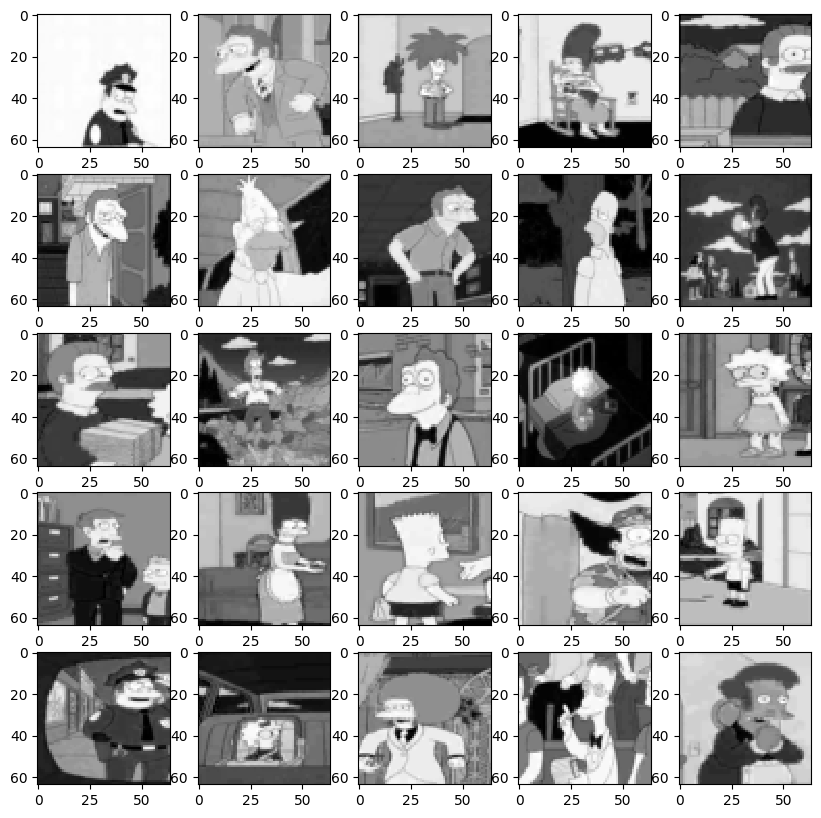

In [19]:
print_result_sep_data(batch, 25) # вывод картинок для себя

In [20]:
# определяем изначальный размер картинки для определения стартового размера слоя
imageTest = batch
print(imageTest.shape)

conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)

x = conv1(imageTest)
print(f'1 {x.shape}')
x = pool(x)
print(f'2 {x.shape}')
x = conv2(x)
print(f'3 {x.shape}')
x = pool(x)
print(f'4 {x.shape}')

# тогда получаем стартовый размер 
start_size_conv = 512*2 #16*13*13
print(f'start_size_conv {start_size_conv}')


torch.Size([128, 3, 64, 64])
1 torch.Size([128, 6, 60, 60])
2 torch.Size([128, 6, 30, 30])
3 torch.Size([128, 16, 26, 26])
4 torch.Size([128, 16, 13, 13])
start_size_conv 1024


# Модель

In [21]:
class ConvNet(nn.Module):    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 5),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 512, 5),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, 3),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),
        )
        
        self.fc1 = nn.Linear(start_size_conv, len(CLASSES))
        # self.fc2 = nn.Linear(512, len(CLASSES))
        # self.fc3 = nn.Linear(128, len(CLASSES))
        # self.fc4 = nn.Linear(64, len(CLASSES))
        
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = x.view(-1, start_size_conv) # сплющели
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        return x

# создали модель
model = ConvNet().to(device)

# print(model)
print(torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [128, 42]                 --
├─Sequential: 1-1                        [128, 64, 30, 30]         --
│    └─Conv2d: 2-1                       [128, 64, 60, 60]         4,864
│    └─BatchNorm2d: 2-2                  [128, 64, 60, 60]         128
│    └─ReLU: 2-3                         [128, 64, 60, 60]         --
│    └─MaxPool2d: 2-4                    [128, 64, 30, 30]         --
├─Sequential: 1-2                        [128, 128, 13, 13]        --
│    └─Conv2d: 2-5                       [128, 128, 26, 26]        204,928
│    └─BatchNorm2d: 2-6                  [128, 128, 26, 26]        256
│    └─ReLU: 2-7                         [128, 128, 26, 26]        --
│    └─MaxPool2d: 2-8                    [128, 128, 13, 13]        --
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─Conv2d: 2-9                       [128, 512, 9, 9]          1,638,91

# Обучение

In [22]:
# создали потери (кроссэнтропия так как у нас много классовая классификация) тут же и совт макс
criterion = nn.CrossEntropyLoss()
# создали оптимизатор стахастический градиентный спуск - получаем скорость обучения
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min')

len_steps = len(train_data)
list_loos = []
# обучение
for epoch in range(EPOCHS):
    list_loos_epoch = []
    # перегрузчик, что бы получить разные партии
    for i, (images, labels) in enumerate(train_data):
        # получаем поддержку графического процессора
        images = images.to(device)
        labels = labels.to(device)
        # проходим вперед
        outputs = model(images)
        # создаем потери
        loss = criterion(outputs, labels)
        list_loos_epoch.append(loss.item())
        # scheduler.step(loss, epoch) # lr <
        # чистка градиента
        optimizer.zero_grad()
        # обратный проход
        loss.backward()
        # оптимизируем шаг
        optimizer.step()
        print(f'Epoch [{epoch+1}/{EPOCHS}], step [{i+1}/{len_steps}], loss {loss.item():.4f}')
    list_loos.append(sum(list_loos_epoch) / float(len(list_loos_epoch)))
print("finish")

Epoch [1/25], step [1/148], loss 3.7613
Epoch [1/25], step [2/148], loss 3.6910
Epoch [1/25], step [3/148], loss 3.5233
Epoch [1/25], step [4/148], loss 3.5514
Epoch [1/25], step [5/148], loss 3.2914
Epoch [1/25], step [6/148], loss 3.2221
Epoch [1/25], step [7/148], loss 3.0325
Epoch [1/25], step [8/148], loss 2.9212
Epoch [1/25], step [9/148], loss 2.9802
Epoch [1/25], step [10/148], loss 2.8292
Epoch [1/25], step [11/148], loss 2.8670
Epoch [1/25], step [12/148], loss 2.8039
Epoch [1/25], step [13/148], loss 2.8746
Epoch [1/25], step [14/148], loss 2.7918
Epoch [1/25], step [15/148], loss 2.7649
Epoch [1/25], step [16/148], loss 2.7400
Epoch [1/25], step [17/148], loss 2.6170
Epoch [1/25], step [18/148], loss 2.4766
Epoch [1/25], step [19/148], loss 2.4318
Epoch [1/25], step [20/148], loss 2.5261
Epoch [1/25], step [21/148], loss 2.5161
Epoch [1/25], step [22/148], loss 2.2814
Epoch [1/25], step [23/148], loss 2.3906
Epoch [1/25], step [24/148], loss 2.6238
Epoch [1/25], step [25/14

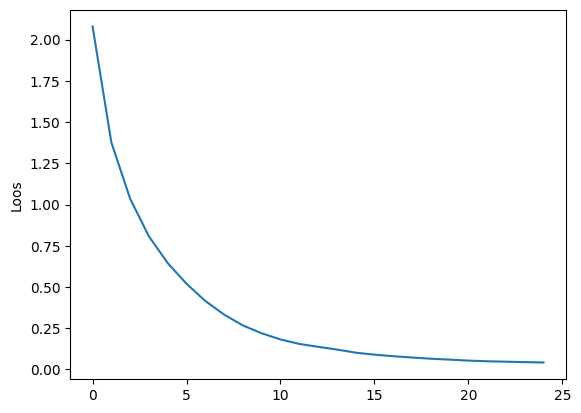

In [23]:
plt.plot([i for i in range(0, EPOCHS)], list_loos)
plt.ylabel('Loos')
plt.show()

# Проверка точности

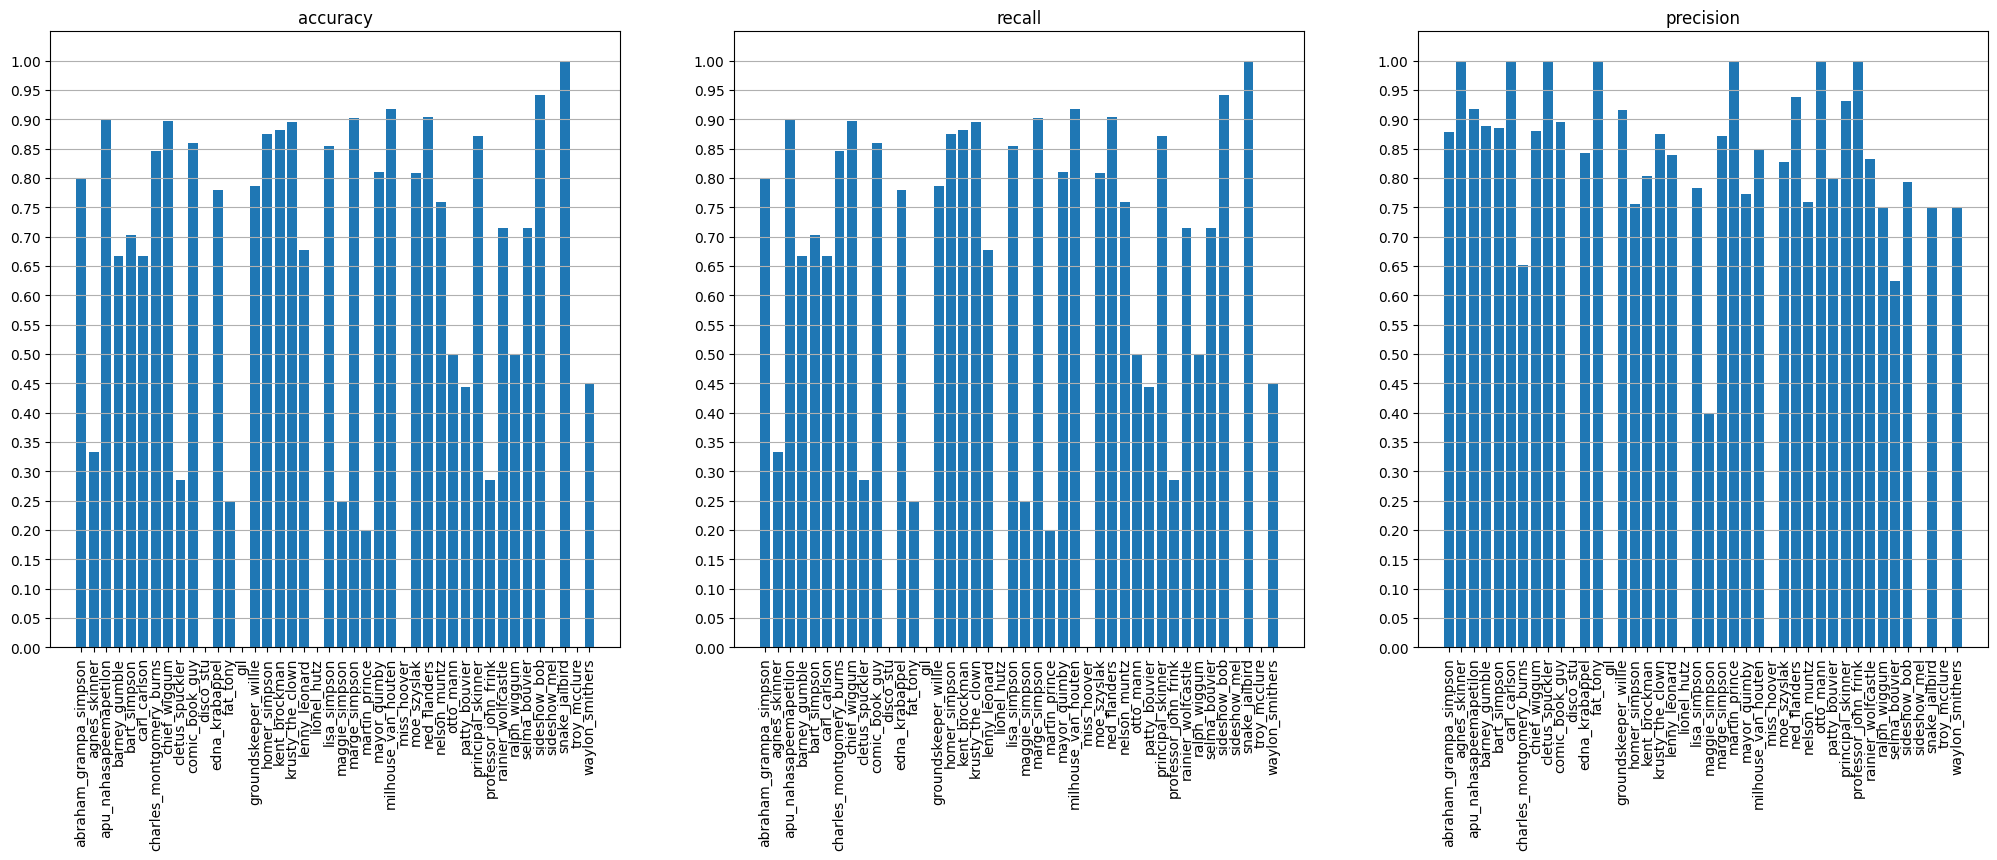

In [24]:
classes = CLASSES
classes_amount = len(CLASSES)

acc = MulticlassAccuracy(num_classes=classes_amount, average=None)
recall = MulticlassRecall(num_classes=classes_amount, average=None)
precision = MulticlassPrecision(num_classes=classes_amount, average=None)
acc.to(device)
recall.to(device)
precision.to(device)

with torch.no_grad():
    model.eval()
    for images, labels in test_data:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        acc.update(outputs, labels)
        recall.update(outputs, labels)
        precision.update(outputs, labels)

    accuracy_per_class = {classname: val.item()
                          for classname, val in zip(classes, acc.compute())}
    recall_per_class = {classname: val.item()
                        for classname, val in zip(classes, recall.compute())}
    precision_per_class = {classname: val.item()
                           for classname, val in zip(classes, precision.compute())}

    total_acc = sum(acc.compute())/classes_amount
    total_rec = sum(recall.compute())/classes_amount
    total_prec = sum(precision.compute())/classes_amount


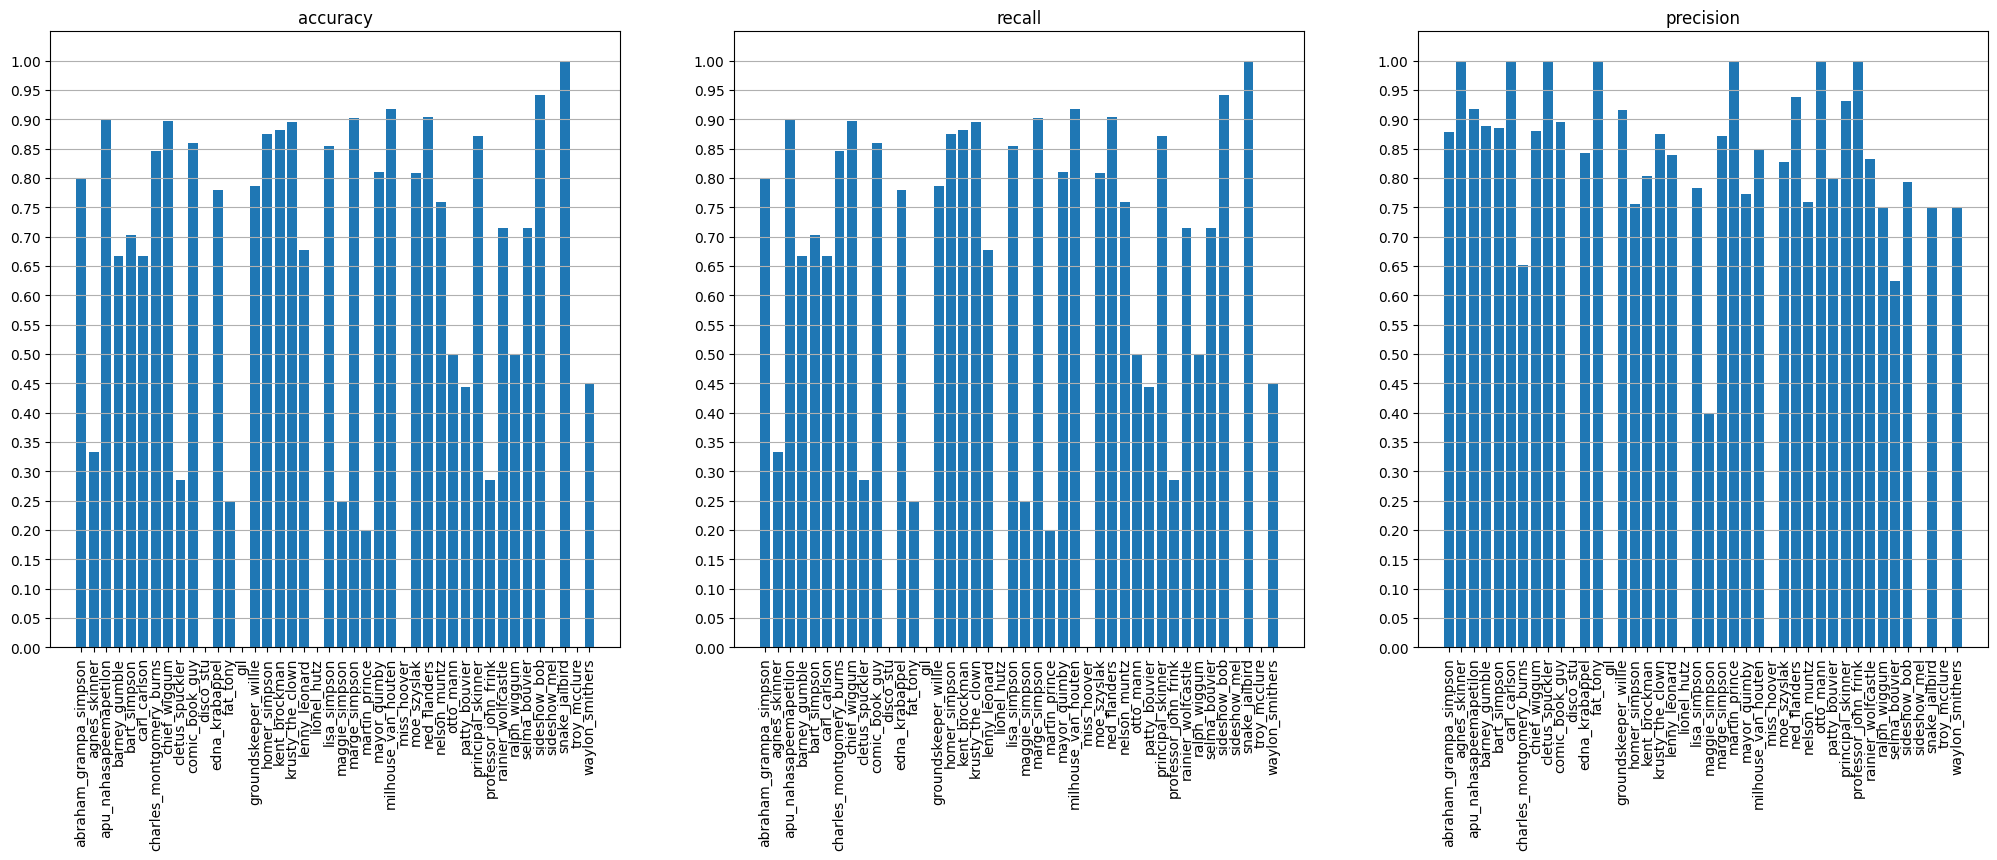

 total_acc: 0.594%
 total_rec: 0.594%
 total_prec: 0.725%


In [30]:
metrics_per_class = {"accuracy": accuracy_per_class,
                     "recall": recall_per_class, "precision": precision_per_class}

fig, axes = plt.subplots(1, 3, figsize=(25, 8))

for (metricName, mVal), ax in zip(metrics_per_class.items(), axes):
    plt.sca(ax)
    plt.bar(mVal.keys(), mVal.values())
    plt.title(metricName)
    plt.grid(axis='y')
    plt.xticks(rotation=90)
    plt.yticks(ticks=np.arange(0, 1.01, 0.05))
plt.show()

print(
    f' total_acc: {total_acc:.3f}%\n total_rec: {total_acc:.3f}%\n total_prec: {total_prec:.3f}%')


In [25]:
# # вычисление точности всей сети
# list_acc = []

# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     n_class__correct = [0 for i in range(len(CLASSES))]
#     n_class__samples = [0 for i in range(len(CLASSES))]
    
#     for images, labels in test_data:
#         images = images.to(device)
#         labels = labels.to(device)
        
#         outputs = model(images)
        
#         # максимальное значение индекс
#         _, predicted = torch.max(outputs, 1)
#         n_samples += labels.size(0)
#         n_correct += (predicted == labels).sum().item()
        
#         for i in range(len(labels)):
#             label = labels[i]
#             pred = predicted[i]
#             if (label == pred):
#                 n_class__correct[label] += 1
#             n_class__samples[label] += 1
            
#     acc = 100 * n_correct / n_samples
#     print(f'Accuracy of the network {acc} %\n\n')
    
#     # вычисление точности для классов
#     for i in range(len(CLASSES)):
#         if (n_class__correct[i] != 0):
#             acc = 100 * n_class__correct[i] / n_class__samples[i]
#             print(f'Accuracy of {CLASSES[i]} {acc} %')
#         else:
#             acc = 0
#             print(f'Accuracy of {CLASSES[i]} {acc} %')
#         list_acc.append(acc)

Accuracy of the network 82.94314381270902 %


Accuracy of abraham_grampa_simpson 79.79797979797979 %
Accuracy of agnes_skinner 33.333333333333336 %
Accuracy of apu_nahasapeemapetilon 90.0 %
Accuracy of barney_gumble 66.66666666666667 %
Accuracy of bart_simpson 70.24793388429752 %
Accuracy of carl_carlson 66.66666666666667 %
Accuracy of charles_montgomery_burns 84.61538461538461 %
Accuracy of chief_wiggum 89.7196261682243 %
Accuracy of cletus_spuckler 28.571428571428573 %
Accuracy of comic_book_guy 86.0 %
Accuracy of disco_stu 0 %
Accuracy of edna_krabappel 78.04878048780488 %
Accuracy of fat_tony 25.0 %
Accuracy of gil 0 %
Accuracy of groundskeeper_willie 78.57142857142857 %
Accuracy of homer_simpson 87.5 %
Accuracy of kent_brockman 88.23529411764706 %
Accuracy of krusty_the_clown 89.47368421052632 %
Accuracy of lenny_leonard 67.74193548387096 %
Accuracy of lionel_hutz 0 %
Accuracy of lisa_simpson 85.52631578947368 %
Accuracy of maggie_simpson 25.0 %
Accuracy of marge_simpson 90.265486

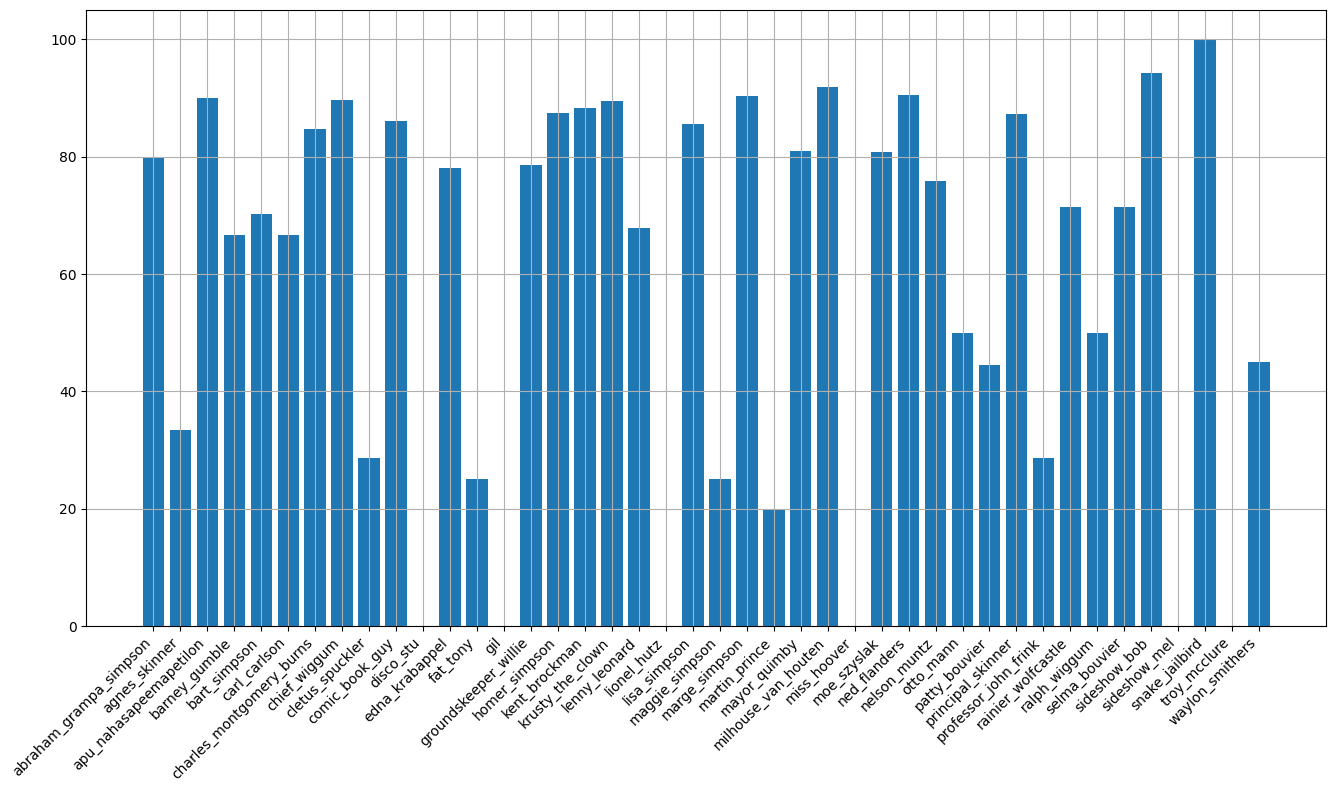

In [26]:
# fig = plt.figure(figsize=(16, 8))

# plt.bar(CLASSES, list_acc)
# plt.grid()
# plt.xticks(rotation=45, ha='right')
# plt.show()

In [27]:
    #     self.conv1 = nn.Sequential(
    #         nn.Conv2d(3, 64, 5),
    #         nn.BatchNorm2d(64),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.conv2 = nn.Sequential(
    #         nn.Conv2d(64, 32, 5),
    #         nn.BatchNorm2d(32),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.conv3 = nn.Sequential(
    #         nn.Conv2d(32, 16, 5),
    #         nn.BatchNorm2d(16),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.fc1 = nn.Linear(start_size_conv, 512)
    #     self.fc2 = nn.Linear(512, 128)
    #     self.fc3 = nn.Linear(128, 64)
    #     self.fc4 = nn.Linear(64, len(CLASSES))
        
    # def forward(self, x: torch.Tensor):
    #     x = self.conv1(x)
    #     x = self.conv2(x)
    #     x = self.conv3(x)
        
    #     x = x.view(-1, start_size_conv) # сплющели
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = F.relu(self.fc3(x))
    #     x = self.fc4(x)
    #     return x
    
    # 50 gпроцентов без 3го, за 10 итераций, за 10 с двумя